# Multi-variate Time Series Forecasting
- This notebook aims to develop a more formal multi-variate time series forecasting approach to determining a golfer's score

In [46]:
import sqlite3
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
import numpy as np

conn = sqlite3.connect('/Users/nickospelt/Documents/App_Projects/PGA_Score_Predictor/Data/PGA_SQL_DB/PGA.db')

## Get Data

In [47]:
model_data_query = """WITH TOURNAMENT_AVERAGES AS (
    SELECT TOURNAMENT_NAME,
        AVG(SG_PUTT) AS TOURN_AVG_SG_PUTT,
        AVG(SG_OFF_THE_TEE) AS TOURN_AVG_SG_OFF_THE_TEE,
        AVG(SG_APPROACH) AS TOURN_AVG_SG_APPROACH,
        AVG(SG_AROUND_THE_GREEN) AS TOURN_AVG_SG_AROUND_THE_GREEN,
        AVG(TOTAL_SCORE_TO_PAR) AS TOURN_AVG_TOTAL_SCORE_TO_PAR
    FROM PLAYER_TOURNAMENT_RESULTS_V3
    GROUP BY 1
)

SELECT PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME, TOURNAMENT_DATE, PLAYER_NAME,
    PAR, LENGTH, ELEVATION,
    R1_TEMP, R1_PRECIP, R1_WIND_SPEED,
    R2_TEMP, R2_PRECIP, R2_WIND_SPEED,
    R3_TEMP, R3_PRECIP, R3_WIND_SPEED,
    R4_TEMP, R4_PRECIP, R4_WIND_SPEED,
    SG_PUTT, TOURN_AVG_SG_PUTT, SG_PUTT - TOURN_AVG_SG_PUTT AS ADJ_SG_PUTT,
    SG_OFF_THE_TEE, TOURN_AVG_SG_OFF_THE_TEE, SG_OFF_THE_TEE - TOURN_AVG_SG_OFF_THE_TEE AS ADJ_SG_OFF_THE_TEE,
    SG_APPROACH, TOURN_AVG_SG_APPROACH, SG_APPROACH - TOURN_AVG_SG_APPROACH AS ADJ_SG_APPROACH,
    SG_AROUND_THE_GREEN, TOURN_AVG_SG_AROUND_THE_GREEN, SG_AROUND_THE_GREEN - TOURN_AVG_SG_AROUND_THE_GREEN AS ADJ_SG_AROUND_THE_GREEN, 
    TOURN_AVG_TOTAL_SCORE_TO_PAR, TOTAL_SCORE_TO_PAR - TOURN_AVG_TOTAL_SCORE_TO_PAR AS ADJ_TOT_SCORE_TO_PAR,
    R1_SCORE - PAR AS R1_SCORE_TO_PAR, R2_SCORE - PAR AS R2_SCORE_TO_PAR, R3_SCORE - PAR AS R3_SCORE_TO_PAR, R4_SCORE - PAR AS R4_SCORE_TO_PAR,
    R1_SCORE, R2_SCORE, R3_SCORE, R4_SCORE, TOTAL_SCORE_TO_PAR
FROM PLAYER_TOURNAMENT_RESULTS_V3
INNER JOIN TOURNAMENT_AVERAGES ON PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME = TOURNAMENT_AVERAGES.TOURNAMENT_NAME
ORDER BY PLAYER_NAME, PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_DATE"""

model_data_df = pd.read_sql_query(model_data_query, conn)
model_data_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PAR,LENGTH,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R2_TEMP,...,ADJ_TOT_SCORE_TO_PAR,R1_SCORE_TO_PAR,R2_SCORE_TO_PAR,R3_SCORE_TO_PAR,R4_SCORE_TO_PAR,R1_SCORE,R2_SCORE,R3_SCORE,R4_SCORE,TOTAL_SCORE_TO_PAR
0,2017 THE PLAYERS Championship,2017-05-11,Aaron Baddeley,72,7189,6.0,78.9,0.000,9.1,79.1,...,1.394366,-2,1,4,0,70,73,76,72,3
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,72,7440,94.0,59.1,0.000,10.3,63.8,...,-0.750000,-3,-4,2,1,69,68,74,73,-4
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,72,7435,201.0,70.8,0.000,18.3,66.6,...,-3.661972,-1,-1,-4,-1,71,71,68,71,-7
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,70,7440,11.0,66.1,0.004,21.4,62.1,...,-0.500000,4,2,7,-1,74,72,77,69,12
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,71,7322,106.0,53.7,1.602,17.5,51.1,...,2.236111,-2,0,0,2,69,71,71,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,72,7340,183.0,78.1,0.000,10.1,81.8,...,8.347826,-3,-3,2,1,69,69,74,73,-3
5288,2018 Valero Texas Open,2018-04-19,Zecheng Dou,72,7435,201.0,70.8,0.000,18.3,66.6,...,3.338028,-1,-1,1,1,71,71,73,73,0
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,70,7412,21.0,72.2,0.000,10.7,69.6,...,14.074627,-3,2,6,8,67,72,76,78,13
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,71,7340,16.0,61.2,0.000,12.7,67.8,...,7.388889,0,-2,1,9,71,69,72,80,8


In [48]:
def weather_weighted_average(temp, precip, wind_speed, elevation):
    weights = [0.1, 0.4, 0.2, 0.3]
    return (temp * -1 * weights[0] + elevation * -1 *weights[1] + precip * weights[2] + wind_speed * weights[3]) / (weights[0] + weights[1] + weights[2] + weights[3])

scaler = StandardScaler()
model_data_df[['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED',
'R2_TEMP', 'R2_PRECIP', 'R2_WIND_SPEED',
'R3_TEMP', 'R3_PRECIP', 'R3_WIND_SPEED', 
'R4_TEMP', 'R4_PRECIP', 'R4_WIND_SPEED', 'ELEVATION']] = scaler.fit_transform(model_data_df[['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED',
'R2_TEMP', 'R2_PRECIP', 'R2_WIND_SPEED', 
'R3_TEMP', 'R3_PRECIP', 'R3_WIND_SPEED', 
'R4_TEMP', 'R4_PRECIP', 'R4_WIND_SPEED', 'ELEVATION']])

model_data_df['R1_WEATHER_FACTOR'] = model_data_df.apply(lambda row:
    weather_weighted_average(row['R1_TEMP'], row['R1_PRECIP'], row['R1_WIND_SPEED'], row['ELEVATION']), axis=1)
model_data_df['R2_WEATHER_FACTOR'] = model_data_df.apply(lambda row:
    weather_weighted_average(row['R2_TEMP'], row['R2_PRECIP'], row['R2_WIND_SPEED'], row['ELEVATION']), axis=1)
model_data_df['R3_WEATHER_FACTOR'] = model_data_df.apply(lambda row:
    weather_weighted_average(row['R3_TEMP'], row['R3_PRECIP'], row['R3_WIND_SPEED'], row['ELEVATION']), axis=1)
model_data_df['R4_WEATHER_FACTOR'] = model_data_df.apply(lambda row:
    weather_weighted_average(row['R4_TEMP'], row['R4_PRECIP'], row['R4_WIND_SPEED'], row['ELEVATION']), axis=1)
model_data_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PAR,LENGTH,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R2_TEMP,...,R4_SCORE_TO_PAR,R1_SCORE,R2_SCORE,R3_SCORE,R4_SCORE,TOTAL_SCORE_TO_PAR,R1_WEATHER_FACTOR,R2_WEATHER_FACTOR,R3_WEATHER_FACTOR,R4_WEATHER_FACTOR
0,2017 THE PLAYERS Championship,2017-05-11,Aaron Baddeley,72,7189,-0.928824,1.477375,-0.338412,-0.605286,1.538345,...,0,70,73,76,72,3,-0.025476,0.317306,0.981257,0.606651
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,72,7440,-0.342815,-1.168057,-0.338412,-0.335730,-0.685256,...,1,69,68,74,73,-4,0.085530,0.196198,1.080353,-0.122401
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,72,7435,0.369719,0.395153,-0.338412,1.461306,-0.278322,...,-1,71,71,68,71,-7,0.183307,0.113740,0.072822,-0.018527
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,70,7440,-0.895528,-0.232804,-0.322663,2.157658,-0.932323,...,-1,74,72,77,69,12,0.964256,0.607373,0.662442,0.606665
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,71,7322,-0.262905,-1.889539,5.969095,1.281603,-2.530990,...,2,69,71,71,73,0,1.872416,0.220411,0.143113,0.525471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,72,7340,0.249853,1.370488,-0.338412,-0.380656,1.930746,...,1,69,69,74,73,-3,-0.418869,-0.677962,-0.332181,-0.451462
5288,2018 Valero Texas Open,2018-04-19,Zecheng Dou,72,7435,0.369719,0.395153,-0.338412,1.461306,-0.278322,...,1,71,71,73,73,0,0.183307,0.113740,0.072822,-0.018527
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,70,7412,-0.828936,0.582203,-0.338412,-0.245879,0.157678,...,8,67,72,76,78,13,0.131908,0.370877,1.388025,0.337408
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,71,7340,-0.862232,-0.887481,-0.338412,0.203381,-0.103922,...,9,71,69,72,80,8,0.426973,0.611445,0.741818,1.297037


## Rory McIlroy

In [49]:
rory_McIlroy_df = model_data_df.loc[model_data_df['PLAYER_NAME'] == 'Xander Schauffele'].sort_values(by='TOURNAMENT_DATE')
rory_McIlroy_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PAR,LENGTH,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R2_TEMP,...,R4_SCORE_TO_PAR,R1_SCORE,R2_SCORE,R3_SCORE,R4_SCORE,TOTAL_SCORE_TO_PAR,R1_WEATHER_FACTOR,R2_WEATHER_FACTOR,R3_WEATHER_FACTOR,R4_WEATHER_FACTOR
5181,2017 Wells Fargo Championship,2017-05-04,Xander Schauffele,72,7396,-0.875551,0.341709,-0.153360,1.730862,0.332078,...,-4,71,70,76,68,-3,0.804636,2.096976,0.865996,0.799086
5182,2017 U.S. Open,2017-06-15,Xander Schauffele,72,7741,1.122208,0.929583,0.279740,-0.313267,0.898878,...,-3,66,73,70,69,-10,-0.579874,-0.685454,-0.570742,0.283220
5183,2017 The Greenbrier Classic,2017-07-06,Xander Schauffele,70,7286,2.787006,0.675729,0.374234,-0.358193,0.869812,...,-3,64,69,66,67,-14,-1.214986,-1.317269,-1.169792,-1.596135
5184,2018 The Players Championship,2018-05-10,Xander Schauffele,72,7189,-0.928824,0.435235,-0.338412,-0.470508,1.000612,...,-5,68,68,71,67,-14,0.119171,-0.031476,0.258032,0.052917
5185,2018 U.S. Open,2018-06-14,Xander Schauffele,70,7440,-0.895528,-0.232804,-0.322663,2.157658,-0.932323,...,-2,72,74,72,68,6,0.964256,0.607373,0.662442,0.606665
5186,2018 WGC-Bridgestone Invitational,2018-08-02,Xander Schauffele,70,7400,0.975705,0.448596,-0.306914,-1.099471,0.695412,...,8,69,73,72,78,12,-0.826366,-1.014850,-1.009019,-0.758260
5187,2018 PGA Championship,2018-08-09,Xander Schauffele,70,7316,0.010122,1.250242,-0.338412,-1.458878,1.363945,...,2,70,67,67,72,-4,-0.634419,-0.573156,-0.343609,-0.658642
5188,2019 Genesis Open,2019-02-14,Xander Schauffele,71,7322,-0.262905,-1.889539,5.969095,1.281603,-2.530990,...,-2,74,68,67,69,-6,1.872416,0.220411,0.143113,0.525471
5189,2019 PGA Championship,2019-05-16,Xander Schauffele,70,7459,-0.722389,-1.261583,-0.216356,-1.054545,-1.150323,...,6,70,69,68,76,3,0.055479,0.106839,0.062548,0.399622
5190,2019 U.S. Open,2019-06-13,Xander Schauffele,71,7075,-0.875551,-1.208140,-0.338412,0.517862,-1.571790,...,-4,66,73,71,67,-7,0.558710,0.407111,0.313721,0.130909


In [50]:
def compute_days_between(date_one, date_two):
    date_1 = datetime.strptime(date_one, "%Y-%m-%d")
    date_2 = datetime.strptime(date_two, "%Y-%m-%d")
    return (date_2 - date_1).days

max_date = rory_McIlroy_df['TOURNAMENT_DATE'].max()
rory_McIlroy_df['DAYS_SINCE'] = rory_McIlroy_df.apply(lambda row: compute_days_between(row['TOURNAMENT_DATE'], max_date), axis=1)
rory_McIlroy_df.sort_values(by='DAYS_SINCE')

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PAR,LENGTH,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R2_TEMP,...,R1_SCORE,R2_SCORE,R3_SCORE,R4_SCORE,TOTAL_SCORE_TO_PAR,R1_WEATHER_FACTOR,R2_WEATHER_FACTOR,R3_WEATHER_FACTOR,R4_WEATHER_FACTOR,DAYS_SINCE
5221,2024 ZOZO CHAMPIONSHIP,2024-10-24,Xander Schauffele,70,7079,-0.422725,0.448596,-0.200607,-0.448045,-0.452722,...,73,65,68,69,-5,-0.050304,-0.030604,-0.246764,1.046512,0
5220,2024 U.S. Open,2024-06-13,Xander Schauffele,70,7569,0.129988,1.116634,-0.322663,-0.762527,1.305812,...,70,69,72,68,-1,-0.456949,-0.512583,-0.598816,-0.487445,133
5219,2024 PGA Championship,2024-05-16,Xander Schauffele,71,7609,-0.009855,-0.045753,-0.275415,-0.874841,-0.249256,...,62,68,68,65,-21,-0.309018,0.157060,-0.615172,-0.657145,161
5218,2024 Wells Fargo Championship,2024-05-09,Xander Schauffele,71,7558,0.722656,0.314988,-0.043117,0.832343,0.172211,...,64,67,70,71,-12,-0.079481,-0.059238,-0.214695,-0.364101,168
5217,2024 THE PLAYERS Championship,2024-03-14,Xander Schauffele,72,7275,-0.928824,-0.874120,-0.338412,-1.121934,-0.002189,...,65,69,65,70,-19,0.054679,-0.008781,0.187989,0.142513,224
5216,2024 The Genesis Invitational,2024-02-15,Xander Schauffele,71,7322,-0.262905,-2.143393,-0.338412,-1.054545,-1.964190,...,70,66,65,70,-13,-0.064545,-0.031183,-0.280981,-0.227263,252
5215,2023 U.S. Open,2023-06-15,Xander Schauffele,70,7421,-0.329497,-0.486658,-0.275415,-0.717601,-0.292856,...,62,70,73,72,-3,-0.089899,0.066872,0.084610,0.057034,497
5214,2023 The Memorial Tournament pres. by Workday,2023-06-01,Xander Schauffele,72,7571,0.729315,0.889501,-0.338412,-0.852378,0.913412,...,77,66,72,74,1,-0.704072,-0.410187,-0.522538,-0.386363,511
5213,2023 PGA Championship,2023-05-18,Xander Schauffele,70,7394,0.063396,-2.811432,-0.338412,-0.852378,-1.034056,...,72,72,71,67,2,-0.067611,0.269872,0.717029,0.071429,525
5212,2023 RBC Heritage,2023-04-13,Xander Schauffele,71,7213,-0.888869,-0.059114,0.575035,0.854806,-0.089389,...,67,66,70,66,-15,0.732908,0.661721,0.483403,0.703478,560


In [51]:
scaler = MinMaxScaler()
rory_McIlroy_df['SCALED_DAYS_SINCE'] = scaler.fit_transform(rory_McIlroy_df[['DAYS_SINCE']])
rory_McIlroy_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PAR,LENGTH,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R2_TEMP,...,R2_SCORE,R3_SCORE,R4_SCORE,TOTAL_SCORE_TO_PAR,R1_WEATHER_FACTOR,R2_WEATHER_FACTOR,R3_WEATHER_FACTOR,R4_WEATHER_FACTOR,DAYS_SINCE,SCALED_DAYS_SINCE
5181,2017 Wells Fargo Championship,2017-05-04,Xander Schauffele,72,7396,-0.875551,0.341709,-0.153360,1.730862,0.332078,...,70,76,68,-3,0.804636,2.096976,0.865996,0.799086,2730,1.000000
5182,2017 U.S. Open,2017-06-15,Xander Schauffele,72,7741,1.122208,0.929583,0.279740,-0.313267,0.898878,...,73,70,69,-10,-0.579874,-0.685454,-0.570742,0.283220,2688,0.984615
5183,2017 The Greenbrier Classic,2017-07-06,Xander Schauffele,70,7286,2.787006,0.675729,0.374234,-0.358193,0.869812,...,69,66,67,-14,-1.214986,-1.317269,-1.169792,-1.596135,2667,0.976923
5184,2018 The Players Championship,2018-05-10,Xander Schauffele,72,7189,-0.928824,0.435235,-0.338412,-0.470508,1.000612,...,68,71,67,-14,0.119171,-0.031476,0.258032,0.052917,2359,0.864103
5185,2018 U.S. Open,2018-06-14,Xander Schauffele,70,7440,-0.895528,-0.232804,-0.322663,2.157658,-0.932323,...,74,72,68,6,0.964256,0.607373,0.662442,0.606665,2324,0.851282
5186,2018 WGC-Bridgestone Invitational,2018-08-02,Xander Schauffele,70,7400,0.975705,0.448596,-0.306914,-1.099471,0.695412,...,73,72,78,12,-0.826366,-1.014850,-1.009019,-0.758260,2275,0.833333
5187,2018 PGA Championship,2018-08-09,Xander Schauffele,70,7316,0.010122,1.250242,-0.338412,-1.458878,1.363945,...,67,67,72,-4,-0.634419,-0.573156,-0.343609,-0.658642,2268,0.830769
5188,2019 Genesis Open,2019-02-14,Xander Schauffele,71,7322,-0.262905,-1.889539,5.969095,1.281603,-2.530990,...,68,67,69,-6,1.872416,0.220411,0.143113,0.525471,2079,0.761538
5189,2019 PGA Championship,2019-05-16,Xander Schauffele,70,7459,-0.722389,-1.261583,-0.216356,-1.054545,-1.150323,...,69,68,76,3,0.055479,0.106839,0.062548,0.399622,1988,0.728205
5190,2019 U.S. Open,2019-06-13,Xander Schauffele,71,7075,-0.875551,-1.208140,-0.338412,0.517862,-1.571790,...,73,71,67,-7,0.558710,0.407111,0.313721,0.130909,1960,0.717949


## Vizualize Historical Trends on a Standard Scale

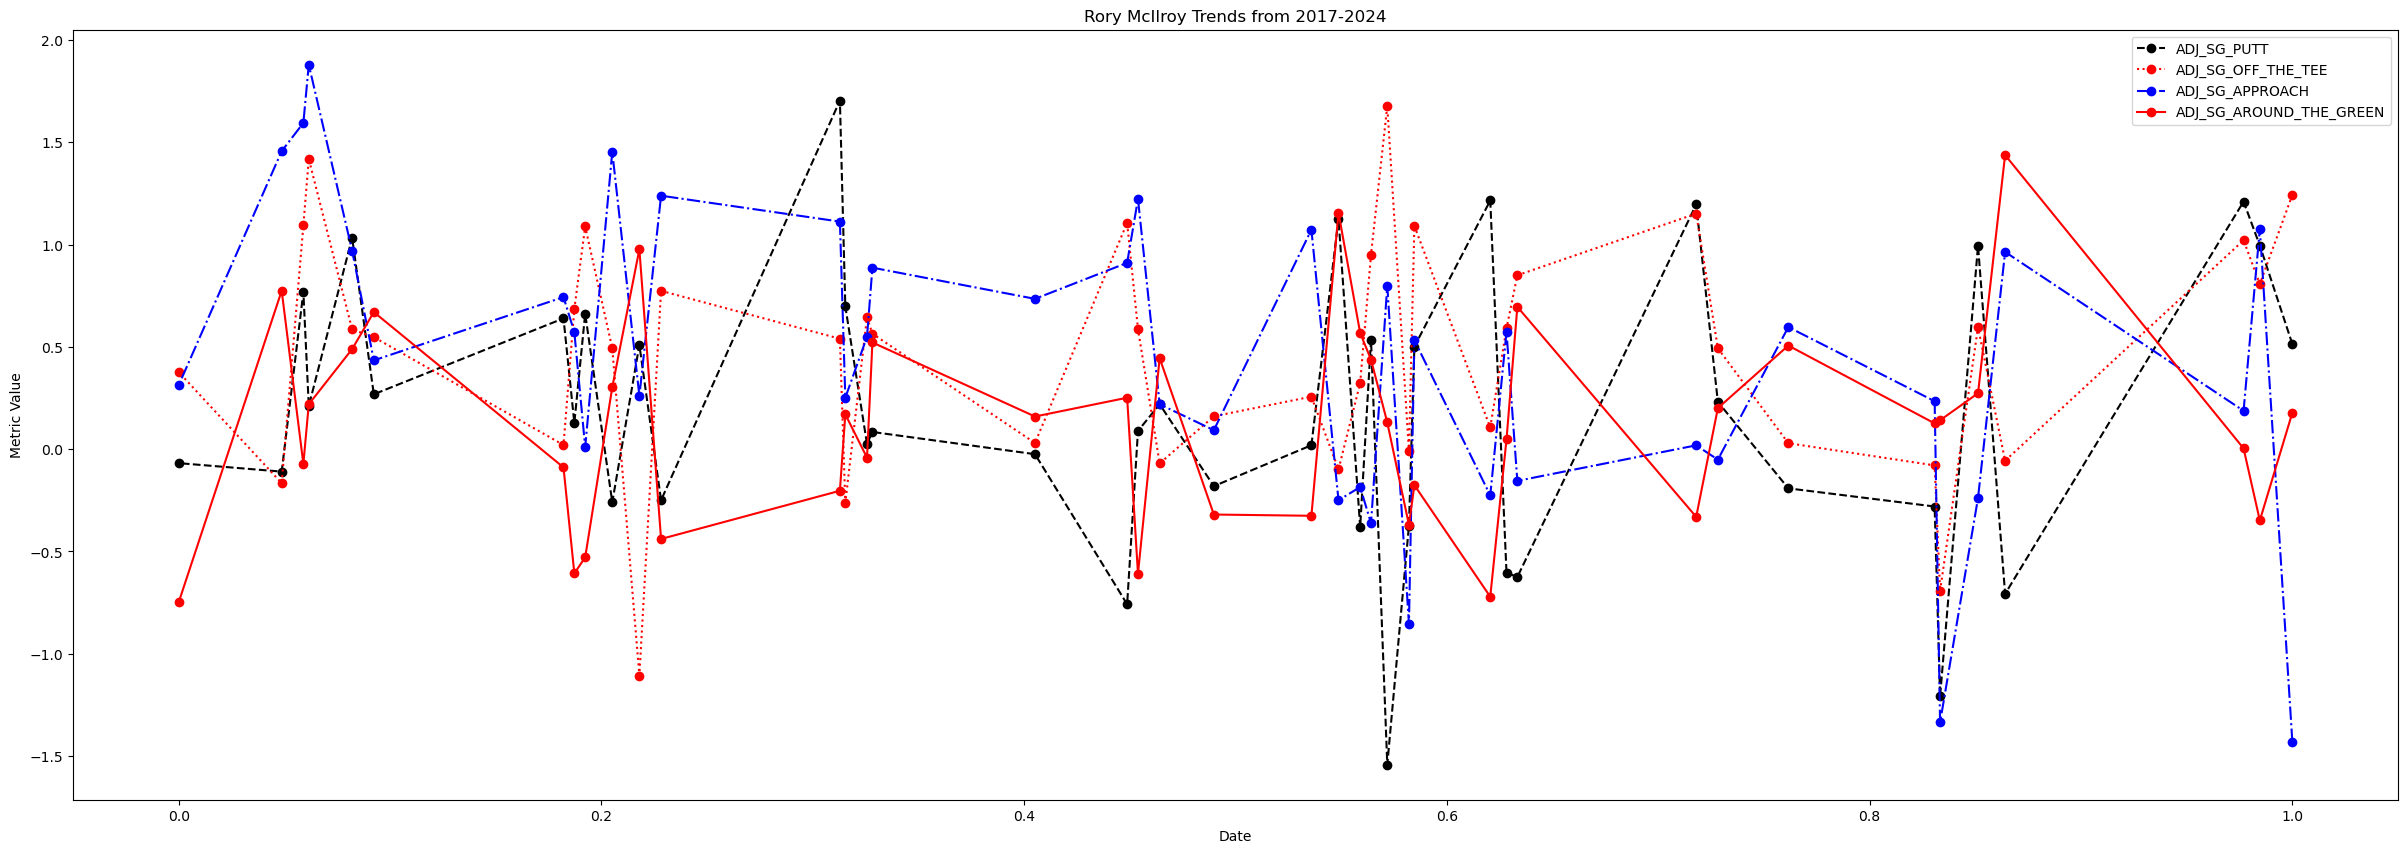

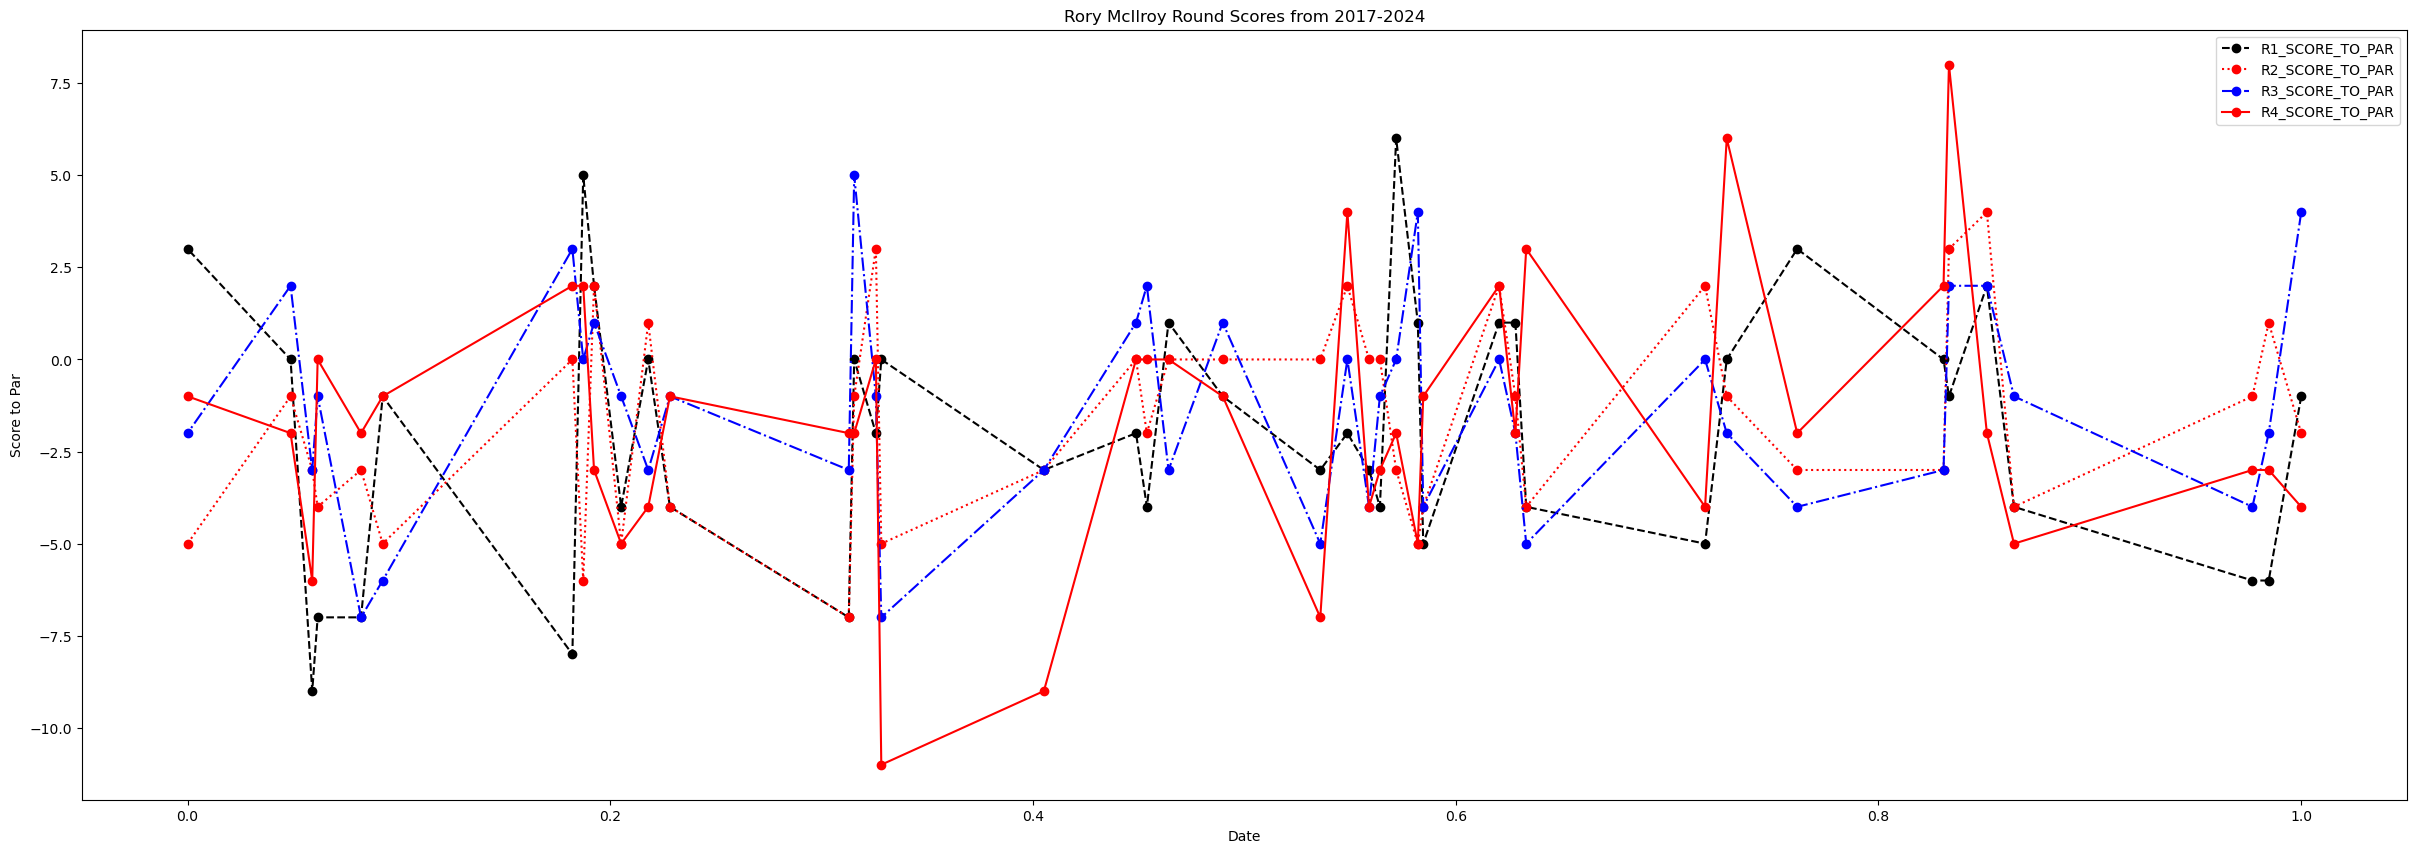

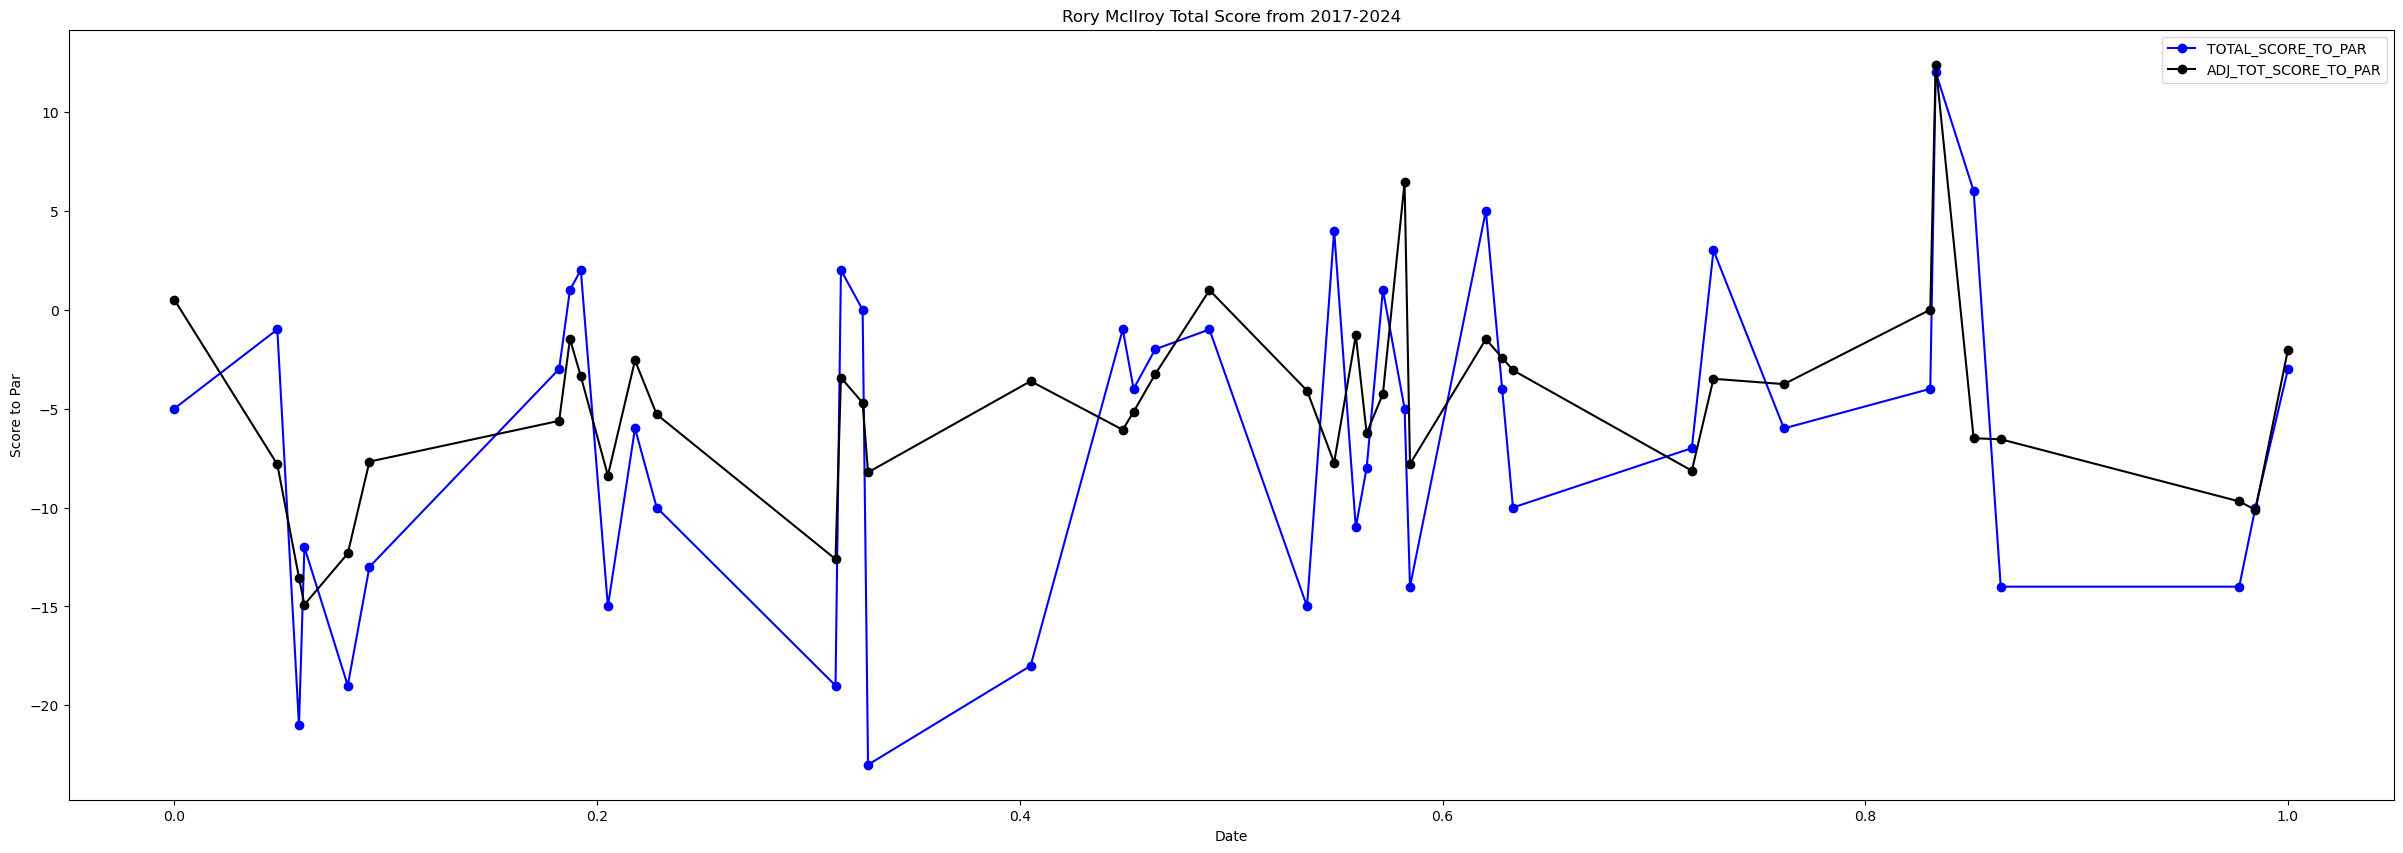

In [52]:
plt.figure(figsize=(30,10))
plt.plot(rory_McIlroy_df['SCALED_DAYS_SINCE'], rory_McIlroy_df['ADJ_SG_PUTT'], color="black", linestyle="--", marker='o', label = 'ADJ_SG_PUTT')
plt.plot(rory_McIlroy_df['SCALED_DAYS_SINCE'], rory_McIlroy_df['ADJ_SG_OFF_THE_TEE'], color="red", linestyle=":", marker='o', label = 'ADJ_SG_OFF_THE_TEE')
plt.plot(rory_McIlroy_df['SCALED_DAYS_SINCE'], rory_McIlroy_df['ADJ_SG_APPROACH'], color="blue", linestyle="-.", marker='o', label = 'ADJ_SG_APPROACH')
plt.plot(rory_McIlroy_df['SCALED_DAYS_SINCE'], rory_McIlroy_df['ADJ_SG_AROUND_THE_GREEN'], color="red", marker='o', label = 'ADJ_SG_AROUND_THE_GREEN')
#plt.plot(rory_McIlroy_df['TOURNAMENT_DATE'], rory_McIlroy_df['R1_SCORE_TO_PAR'], color="blue", marker='o', label = 'R1_SCORE_TO_PAR')

plt.title(f"Rory McIlroy Trends from 2017-2024")
plt.xlabel('Date')
plt.ylabel('Metric Value')
plt.legend()

plt.figure(figsize=(30,10))
plt.plot(rory_McIlroy_df['SCALED_DAYS_SINCE'], rory_McIlroy_df['R1_SCORE_TO_PAR'], color="black", linestyle="--", marker='o', label = 'R1_SCORE_TO_PAR')
plt.plot(rory_McIlroy_df['SCALED_DAYS_SINCE'], rory_McIlroy_df['R2_SCORE_TO_PAR'], color="red", linestyle=":", marker='o', label = 'R2_SCORE_TO_PAR')
plt.plot(rory_McIlroy_df['SCALED_DAYS_SINCE'], rory_McIlroy_df['R3_SCORE_TO_PAR'], color="blue", linestyle="-.", marker='o', label = 'R3_SCORE_TO_PAR')
plt.plot(rory_McIlroy_df['SCALED_DAYS_SINCE'], rory_McIlroy_df['R4_SCORE_TO_PAR'], color="red", marker='o', label = 'R4_SCORE_TO_PAR')
#plt.plot(rory_McIlroy_df['TOURNAMENT_DATE'], rory_McIlroy_df['TOTAL_SCORE_TO_PAR'], color="blue", marker='o', label = 'TOTAL_SCORE_TO_PAR')

plt.title(f"Rory McIlroy Round Scores from 2017-2024")
plt.xlabel('Date')
plt.ylabel('Score to Par')
plt.legend()

plt.figure(figsize=(30,10))
plt.plot(rory_McIlroy_df['SCALED_DAYS_SINCE'], rory_McIlroy_df['TOTAL_SCORE_TO_PAR'], color="blue", marker='o', label = 'TOTAL_SCORE_TO_PAR')
plt.plot(rory_McIlroy_df['SCALED_DAYS_SINCE'], rory_McIlroy_df['ADJ_TOT_SCORE_TO_PAR'], color='black', marker='o', label = 'ADJ_TOT_SCORE_TO_PAR')
plt.title(f"Rory McIlroy Total Score from 2017-2024")
plt.xlabel('Date')
plt.ylabel('Score to Par')
plt.legend()

- Trends are clumped based on which tournaments were picked for the dataset.
- What is the best way to generate predictions off of this?
- Can make stationary by differencing the previous value in the dataset.

## Correlation between Metrics and Score

In [53]:
features_and_targets = ['PAR', 'LENGTH', 
    'R1_WEATHER_FACTOR', 'R2_WEATHER_FACTOR', 'R3_WEATHER_FACTOR', 'R4_WEATHER_FACTOR', 
    'ADJ_SG_PUTT', 'ADJ_SG_OFF_THE_TEE', 'ADJ_SG_APPROACH', 'ADJ_SG_AROUND_THE_GREEN',
    'R1_SCORE_TO_PAR', 'R2_SCORE_TO_PAR', 'R3_SCORE_TO_PAR', 'R4_SCORE_TO_PAR',
    'TOTAL_SCORE_TO_PAR']

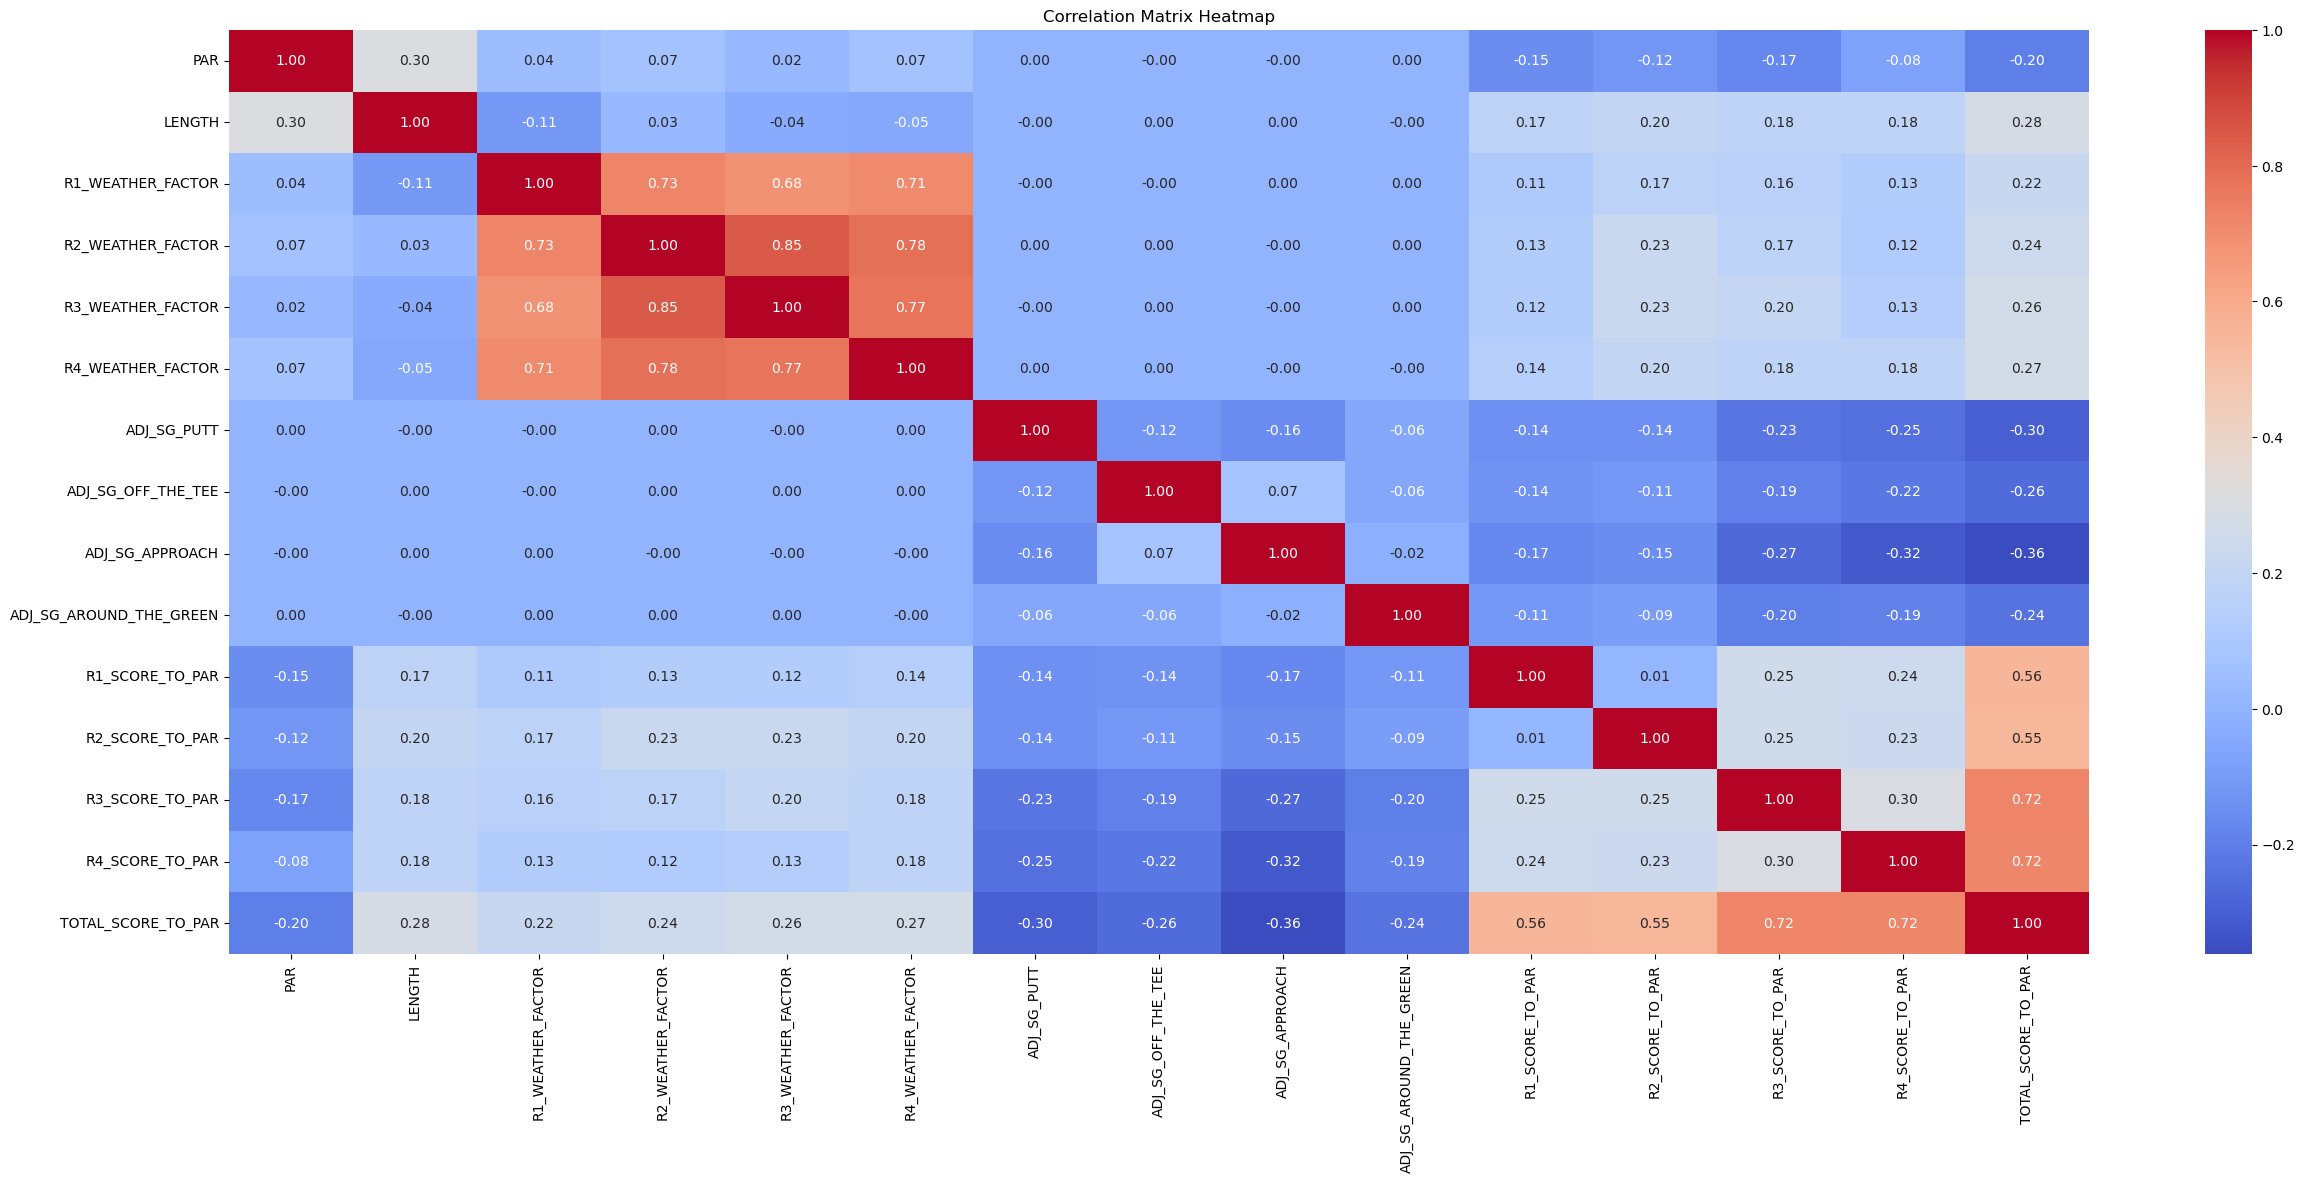

In [54]:
# Compute correlation matrix
correlation_matrix = model_data_df[features_and_targets].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(30, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

- High correlation between the adjusted strokes gained metrics and the score. 
- How to use the historical values to generate best predicitions for round scores? 